In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../../data/kosdaq/price.csv", index_col='date', parse_dates=True)
sn = pd.read_csv("../../data/kosdaq/share_number.csv", index_col='date', parse_dates=True)
pm = pd.read_csv("../../data/kosdaq/price_mod.csv", index_col = 'date', parse_dates = True)

gp_t = pd.read_csv("../../data/kosdaq/gross_profit.csv", index_col='date', parse_dates=True)
ast_t = pd.read_csv("../../data/kosdaq/asset.csv", index_col='date', parse_dates=True)

In [3]:
# 시가총액
market_cap = df*sn
market_cap.index = market_cap.index + pd.tseries.offsets.MonthEnd(0)
m_cap = market_cap.groupby('date').last()

# 월간 수익률
pm.index = pm.index + pd.tseries.offsets.MonthEnd(0)
m_pm = pm.groupby('date').last()
m_ret = (m_pm.fillna(-1) / m_pm.shift(1)).clip(0, 10) - 1

# 해당 연도 재무 데이터는 다음 연도 2분기에 알 수 있다고 가정
gp = pd.DataFrame(index=m_ret.index).join(gp_t).ffill().shift(15)
ast = pd.DataFrame(index=m_ret.index).join(ast_t).ffill().shift(15)

pf = gp/ast  # profit_factor

In [4]:
gpoa_rank = pf.rank(axis=1, pct=True, ascending=False)
p1_mask = gpoa_rank <= 0.2
p2_mask = (gpoa_rank > 0.2) & (gpoa_rank <= 0.4)
p3_mask = (gpoa_rank > 0.4) & (gpoa_rank <= 0.6)
p4_mask = (gpoa_rank > 0.6) & (gpoa_rank <= 0.8)
p5_mask = (gpoa_rank > 0.8) & (gpoa_rank <= 1.0)

gpoa_cap_weight = [(m_cap[i].T / m_cap[i].sum(axis=1)).T for i in [p1_mask, p2_mask, p3_mask, p4_mask, p5_mask]]

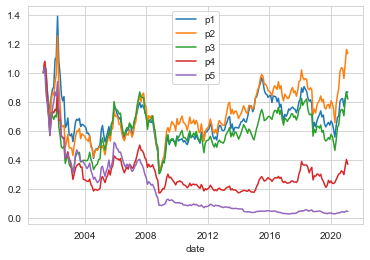

In [5]:
p1_cr = ((m_ret * gpoa_cap_weight[0].shift(1)).sum(axis=1) + 1).cumprod()[15:]
p2_cr = ((m_ret * gpoa_cap_weight[1].shift(1)).sum(axis=1) + 1).cumprod()[15:]
p3_cr = ((m_ret * gpoa_cap_weight[2].shift(1)).sum(axis=1) + 1).cumprod()[15:]
p4_cr = ((m_ret * gpoa_cap_weight[3].shift(1)).sum(axis=1) + 1).cumprod()[15:]
p5_cr = ((m_ret * gpoa_cap_weight[4].shift(1)).sum(axis=1) + 1).cumprod()[15:]

sns.set_style('whitegrid')
sns.lineplot(p1_cr.index, p1_cr, label = 'p1')
sns.lineplot(p2_cr.index, p2_cr, label = 'p2')
sns.lineplot(p3_cr.index, p3_cr, label = 'p3')
sns.lineplot(p4_cr.index, p4_cr, label = 'p4')
sns.lineplot(p5_cr.index, p5_cr, label = 'p5')
plt.show()

In [6]:
# quality factor를 구하기 위한 추가 데이터 read
lb = pd.read_csv("../../data/kosdaq/liability.csv", index_col = 'date', parse_dates = True)
cf = pd.read_csv("../../data/kosdaq/cashflow.csv", index_col = 'date', parse_dates = True)
sl = pd.read_csv("../../data/kosdaq/sales.csv", index_col = 'date', parse_dates = True)

lb = pd.DataFrame(index=m_ret.index).join(lb).ffill().shift(15)
cf = pd.DataFrame(index=m_ret.index).join(cf).ffill().shift(15)
sl = pd.DataFrame(index=m_ret.index).join(sl).ffill().shift(15)

In [7]:
n = 60
m = 60
# 수익성 팩터
gpoa = gp/ast # gross profit over asset
cfoa = cf/ast # cashflow profit over asset
gmar = gp/sl  # gross margin
turn = sl/ast

# 성장성 팩터(수익성 팩터, 5년 전과 비교해서 변화 정도 / 총자산)
gpoa_d = (gpoa - gpoa.shift(n))/ ast.shift(n)
cfoa_d = (cfoa - cfoa.shift(n))/ ast.shift(n)
gmar_d = (gmar - gmar.shift(n))/ sl.shift(n)
turn_d = sl/ast - sl.shift(12)/ast.shift(12)

# 안정성 팩터
lev = lb/ast # 총부채 / 총자산
gpvol = gpoa.rolling(m).std()  # gross profit volatility
cfvol = cfoa.rolling(m).std()  # cashflow volatility

In [8]:
gpoa_rank = gpoa.rank(axis=1, ascending=False)
cfoa_rank = cfoa.rank(axis=1, ascending=False)
gmar_rank = gmar.rank(axis=1, ascending=False)
turn_rank = turn.rank(axis=1, ascending=False)
gpoa_d_rank = gpoa_d.rank(axis=1, ascending=False)
cfoa_d_rank = cfoa_d.rank(axis=1, ascending=False)
gmar_d_rank = gmar_d.rank(axis=1, ascending=False)
turn_d_rank = turn_d.rank(axis=1, ascending=False)
lev_rank = lev.rank(axis=1)
gpvol_rank = gpvol.rank(axis=1)
cfvol_rank = cfvol.rank(axis=1)

gpoa_z = (gpoa_rank.T - gpoa_rank.mean(axis=1)) / gpoa_rank.std(axis=1)
cfoa_z = (cfoa_rank.T - cfoa_rank.mean(axis=1)) / cfoa_rank.std(axis=1)
gmar_z = (gmar_rank.T - gmar_rank.mean(axis=1)) / gmar_rank.std(axis=1)
turn_z = (turn_rank.T - turn_rank.mean(axis=1)) / turn_rank.std(axis=1)
gpoa_d_z = (gpoa_d_rank.T - gpoa_d_rank.mean(axis=1)) / gpoa_d_rank.std(axis=1)
cfoa_d_z = (cfoa_d_rank.T - cfoa_d_rank.mean(axis=1)) / cfoa_d_rank.std(axis=1)
gmar_d_z = (gmar_d_rank.T - gmar_d_rank.mean(axis=1)) / gmar_d_rank.std(axis=1)
turn_d_z = (turn_d_rank.T - turn_d_rank.mean(axis=1)) / turn_d_rank.std(axis=1)
lev_z = (lev_rank.T - lev_rank.mean(axis=1)) / lev_rank.std(axis=1)
gpvol_z = (gpvol_rank.T - gpvol_rank.mean(axis=1)) / gpvol_rank.std(axis=1)
cfvol_z = (cfvol_rank.T - cfvol_rank.mean(axis=1)) / cfvol_rank.std(axis=1)

total_z = gpoa_z.T + cfoa_z.T + gmar_z.T + turn_z.T + gpoa_d_z.T + cfoa_d_z.T + gmar_d_z.T + turn_d_z.T + lev_z.T + gpvol_z.T + cfvol_z.T
total_z = ((total_z.T - total_z.mean(axis=1)) / total_z.std(axis=1)).T

In [9]:
total_rank = total_z.rank(axis=1, pct=True)
p1_mask = total_rank <= 0.2
p2_mask = (total_rank > 0.2) & (total_rank <= 0.4)
p3_mask = (total_rank > 0.4) & (total_rank <= 0.6)
p4_mask = (total_rank > 0.6) & (total_rank <= 0.8)
p5_mask = (total_rank > 0.8) & (total_rank <= 1.0)

profit_cap_weight = [(m_cap[i].T / m_cap[i].sum(axis=1)).T for i in [p1_mask, p2_mask, p3_mask, p4_mask, p5_mask]]

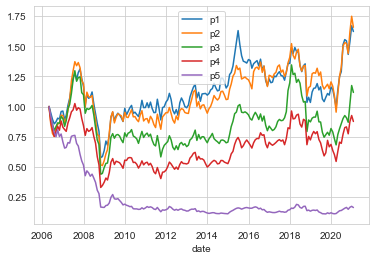

In [10]:
n = m if n < m else n
p1_cr = ((m_ret * profit_cap_weight[0].shift(1)).sum(axis=1) + 1).cumprod()[n + 15:]
p2_cr = ((m_ret * profit_cap_weight[1].shift(1)).sum(axis=1) + 1).cumprod()[n + 15:]
p3_cr = ((m_ret * profit_cap_weight[2].shift(1)).sum(axis=1) + 1).cumprod()[n + 15:]
p4_cr = ((m_ret * profit_cap_weight[3].shift(1)).sum(axis=1) + 1).cumprod()[n + 15:]
p5_cr = ((m_ret * profit_cap_weight[4].shift(1)).sum(axis=1) + 1).cumprod()[n + 15:]

sns.set_style('whitegrid')
sns.lineplot(p1_cr.index, p1_cr, label = 'p1')
sns.lineplot(p2_cr.index, p2_cr, label = 'p2')
sns.lineplot(p3_cr.index, p3_cr, label = 'p3')
sns.lineplot(p4_cr.index, p4_cr, label = 'p4')
sns.lineplot(p5_cr.index, p5_cr, label = 'p5')
plt.show()